In [1]:
from skimage import img_as_float, img_as_uint, io
import numpy as np
import glob

In [2]:
def splitRGBNegatives(img, cut = 0.05):
    
    img = img_as_float(img)
    
    imgRow, imgCol = img.shape[:2]
    imgRow -= imgRow % 3

    channelRowCut = int(imgRow // 3 * cut)
    channelColCut = int(imgCol * cut)
    channelSize = imgRow // 3

    r = img[2 * channelSize + channelRowCut : imgRow - channelRowCut,
            channelColCut: -channelColCut]
   
    g = img[channelSize + channelRowCut: 2 * channelSize - channelRowCut,
            channelColCut: -channelColCut]
    
    b = img[channelRowCut: channelSize - channelRowCut,
            channelColCut: -channelColCut]
    
    return {
        'r': r,
        'g': g,
        'b': b
    }

In [3]:
def getBestOffsets(imgOne, imgTwo):
    
    initalOffset = 256
    corrXArray = []
    corrYArray = []
    imgTwoX = np.roll(imgTwo, -initalOffset, axis = 0)
    imgTwoY = np.roll(imgTwo, -initalOffset, axis = 1)
    
    # двигаем относительно первой
    for i in range(initalOffset * 2):
        corrX = (imgOne * imgTwoX).sum()        
        corrY = (imgOne * imgTwoY).sum()
        corrXArray.append([corrX, i - initalOffset])
        corrYArray.append([corrY, i - initalOffset])
        imgTwoX = np.roll(imgTwoX, 1, axis = 0)
        imgTwoY = np.roll(imgTwoY, 1, axis = 1)
        
    corrXArray = np.array(corrXArray)
    bestX = corrXArray[np.argmax(corrXArray[:, 0])].astype(int)[1]
    
    corrYArray = np.array(corrYArray)
    bestY = corrYArray[np.argmax(corrYArray[:, 0])].astype(int)[1]
    
    return (bestX, bestY)

In [4]:
def createCanalsImg(img):
    
    imgs = splitRGBNegatives(img, 0.05)
    r = imgs['r']
    g = imgs['g']
    b = imgs['b']
    
    # зелёный канал не трогаем, он основной
    rOffsets = getBestOffsets(g, r)
    r = np.roll(r, rOffsets, axis = (0, 1))
    
    bOffsets = getBestOffsets(g, b)
    b = np.roll(b, bOffsets, axis = (0, 1))

    totalCut = (max(abs(bOffsets[0]), abs(rOffsets[0])), 
                    max(abs(bOffsets[1]), abs(rOffsets[1])))

    b = b[totalCut[0]: b.shape[0] - totalCut[0],
          totalCut[1]: b.shape[1] - totalCut[1]]
    g = g[totalCut[0]: g.shape[0] - totalCut[0],
          totalCut[1]: g.shape[1] - totalCut[1]]
    r = r[totalCut[0]: r.shape[0] - totalCut[0],
          totalCut[1]: r.shape[1] - totalCut[1]]
    
    return img_as_float(np.dstack((r, g, b)))

00313v.jpg


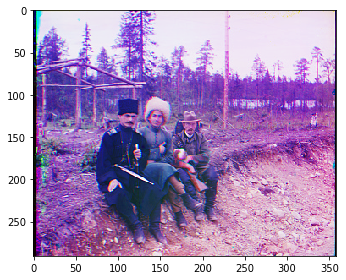

00876v.jpg


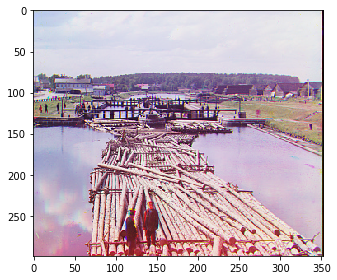

00882v.jpg


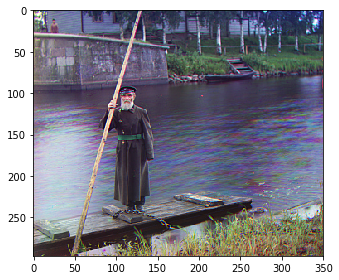

00884v.jpg


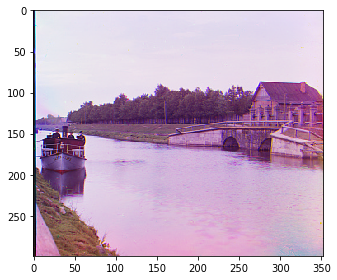

00917v.jpg


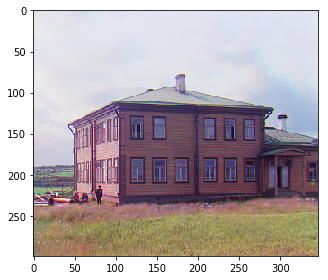

00938v.jpg


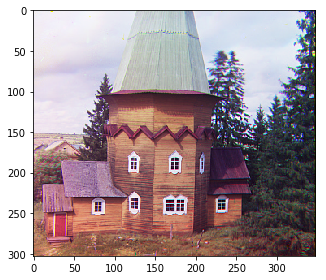

1.jpg


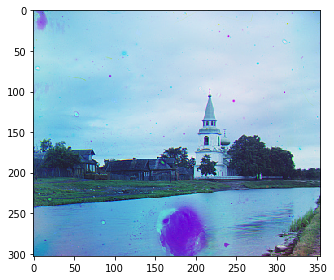

2.jpg


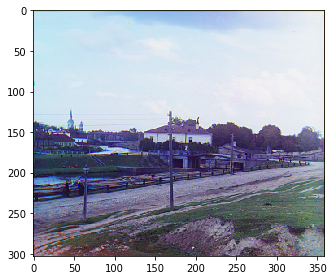

00.png


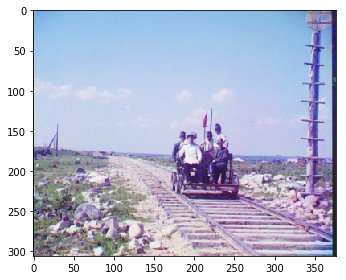

01.png


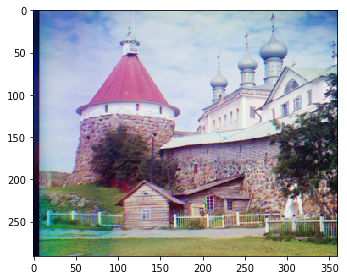

02.png


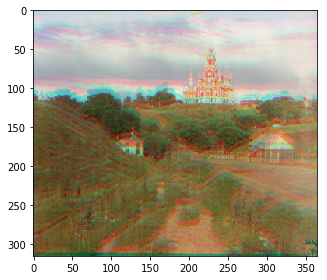

03.png


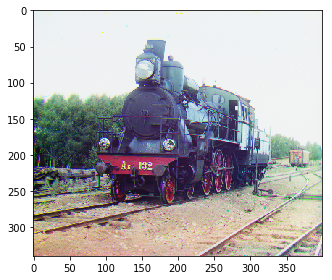

In [6]:
fullGlob = glob.glob("*.jpg") + glob.glob("*.png")

for file in fullGlob:
    print(file)
    img = createCanalsImg(io.imread(file))
    io.imshow(img)
    io.show()